### Grade CAMM Implementation

In [1]:
import os
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
from torchvision import models

In [2]:
from model_def import CropDiseaseCNN
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
%matplotlib inline 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 38
model = CropDiseaseCNN(num_classes=num_classes)

checkpoint = torch.load(r"D:\BCY 3rd Year\EPICS\P1\model\crop_disease_model.pth", map_location=device)
model.load_state_dict(checkpoint["model_state"])
class_names = checkpoint["class_names"]

model.to(device)
model.eval()


C:\Users\sohal\AppData\Local\Temp\ipykernel_18540\1158764589.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"D:\BCY 3rd Year\EPICS\P1\model\cro

CropDiseaseCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=38, bias=True)
  )
)

In [5]:
print("Classes:", class_names)

Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___

In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [11]:
img_path = r"D:\BCY 3rd Year\EPICS\P1\Dataset\leaf_image.jpg"

image = cv2.imread(img_path)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

input_tensor = transform(image).unsqueeze(0).to(device)

In [12]:
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

print("Predicted Class Index:", predicted_class)
print("Predicted Disease:", class_names[predicted_class])

Predicted Class Index: 2
Predicted Disease: Apple___Cedar_apple_rust


In [13]:
target_layer = model.features[6]



In [15]:
cam = GradCAM(model=model, target_layers=[target_layer])

targets = [ClassifierOutputTarget(predicted_class)]

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

heatmap = grayscale_cam[0]

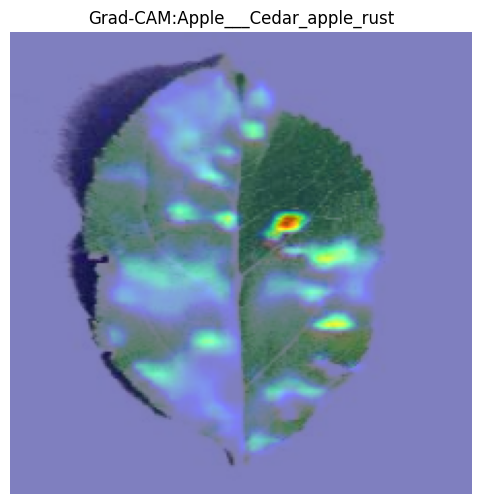

In [20]:
resized_image = cv2.resize(image, (224,224))

rgb_img = resized_image.astype(np.float32)/255.0

visualization = show_cam_on_image(rgb_img, heatmap, use_rgb=True)

plt.figure(figsize=(6,6))
plt.imshow(visualization)
plt.title(f"Grad-CAM:{class_names[predicted_class]}")
plt.axis("off")
plt.show()